# RAIL Demostration on HSC dataset

This is a notebook demonstrating some of the estimation and evaluation features of the `RAIL` packages, running on a subset of the publically available HSC Y3 dataset. 

The `rail.estimation` subpackage contains infrastructure to run multiple production-level photo-z codes.  There is a minimimal superclass that sets up some file paths and variable names. Each specific photo-z code resides in a subclass in `rail.estimation.algos` with algorithm-specific setup variables.  More extensive documentation is available on Read the Docs here:
https://rail-hub.readthedocs.io/en/latest/


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

In [2]:
import rail
import qp
from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.core.point_estimation import PointEstimationMixin

We'll start by setting up the `DataStore`.  RAIL uses [`ceci`](https://github.com/LSSTDESC/ceci) as a back-end for pipelines of RAIL stages run at the command line. The `DataStore` is a workaround to enable `ceci` to interact with data files in an interactive notebook environment.   Some files will appear in the `DataStore` with the prefix "inprogress_" as they are stored in memory for use in the notebook, but the data will also be written out to file with the prefix "output_".  See the Golden Spike end-to-end demo notebook for more details on the `DataStore`.

In [3]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

We load the data into the `TableHandle` with the `DataStore.read_file()`

In [4]:
trainFile = "./data/dered_pdr3_wide_train_curated.pq"
testFile = "./data/dered_pdr3_wide_test_curated.pq"

training_data = DS.read_file("training_data", TableHandle, trainFile)
test_data = DS.read_file("test_data", TableHandle, testFile)

column_list None
column_list None


## Set common parameters

We start by setting the common parameters to all stages, such as name of the bands, the reference band, the name of the magnitude error, and magnitude limit. We also ask all estimation stages to compute mode and median as point estimate by `calculated_point_estimates = ['zmode', 'zmedian']`

In [5]:
from rail.core import common_params

In [6]:
common_params.set_param_defaults(
    mag_limits={
        "g_HSCMag": 27.8,
        "r_HSCMag": 27.1,
        "i_HSCMag": 26.6,
        "z_HSCMag": 26.6,
        "y_HSCMag": 25.6,
    },
    bands=[f"{band}_HSCMag" for band in "grizy"],
    ref_band="i_HSCMag",
    err_bands=[f"{band}_HSCMagErr" for band in "grizy"],
    calculated_point_estimates=["zmode", "zmedian"],
)

## A simple k-NN model
Each photo-z algorithm has code-specific parameters necessary to initialize the code.  These values can be input on the command line, or passed in via a dictionary.<br>

Let's start with a very simple demonstration using `k_nearneigh`, a RAIL wrapper around `sklearn`'s nearest neighbor (NN) method.  It calculates a normalized weight for the K nearest neighbors based on their distance and makes a PDF as a sum of K Gaussians, each at the redshift of the training galaxy with amplitude based on the distance weight, and a Gaussian width set by the user.  This is a toy model estimator, but it actually performs very well for representative data sets. There are configuration parameters for the names of columns, random seeds, etc... in `KNearNeighEstimator` with best-guess sensible defaults based on preliminary experimentation in DESC. See the [KNearNeigh code](https://github.com/LSSTDESC/RAIL/blob/eac-dev/rail/estimation/algos/k_nearneigh.py) for more details, but here is a minimal set to run:

In [7]:
knn_dict = dict(
    zmin=0.0,
    zmax=3.0,
    nzbins=301,
    trainfrac=0.75,
    sigma_grid_min=0.01,
    sigma_grid_max=0.07,
    ngrid_sigma=10,
    nneigh_min=3,
    nneigh_max=7,
    hdf5_groupname="",
)

we create the knn informer by feeding the configuration to the `make_stage` function. The `name` is specified for ceci to recognize the stage. 

In [8]:
from rail.estimation.algos.k_nearneigh import KNearNeighInformer, KNearNeighEstimator

knn_informer = KNearNeighInformer.make_stage(
    name="inform_KNN", model="./model/demo_knn.pkl", **knn_dict
)

The inform step find the best fit parameters for the knn

In [9]:
%%time
knn_informer.inform(training_data)

split into 15000 training and 5000 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.023333333333333334 and numneigh=7



Inserting handle into data store.  model_inform_KNN: model/inprogress_demo_knn.pkl, inform_KNN
CPU times: user 21.9 s, sys: 3.34 s, total: 25.3 s
Wall time: 25.3 s


We make the knn estimator stage using the same configurations. 

In [10]:
knn_estimator = KNearNeighEstimator.make_stage(
    name="estimate_KNN",
    model="./model/demo_knn.pkl",
    output="./output/knn_output.hdf5",
    **knn_dict
)

Running the `estimate` function to estimate the photo-z for the `test_data`

In [11]:
%%time

results_knn = knn_estimator.estimate(test_data)

Inserting handle into data store.  model: ./model/demo_knn.pkl, estimate_KNN
Process 0 running estimator on chunk 0 - 10000
Process 0 estimating PZ PDF for rows 0 - 10,000
Inserting handle into data store.  output_estimate_KNN: output/inprogress_knn_output.hdf5, estimate_KNN
Process 0 running estimator on chunk 10000 - 20000
Process 0 estimating PZ PDF for rows 10,000 - 20,000
CPU times: user 4.6 s, sys: 561 ms, total: 5.16 s
Wall time: 5.19 s


In [12]:
zmode_knn = results_knn().ancil["zmode"].flatten()
zmedian_knn = results_knn().ancil["zmedian"].flatten()

Text(0, 0.5, 'k-NN photo-z Mode')

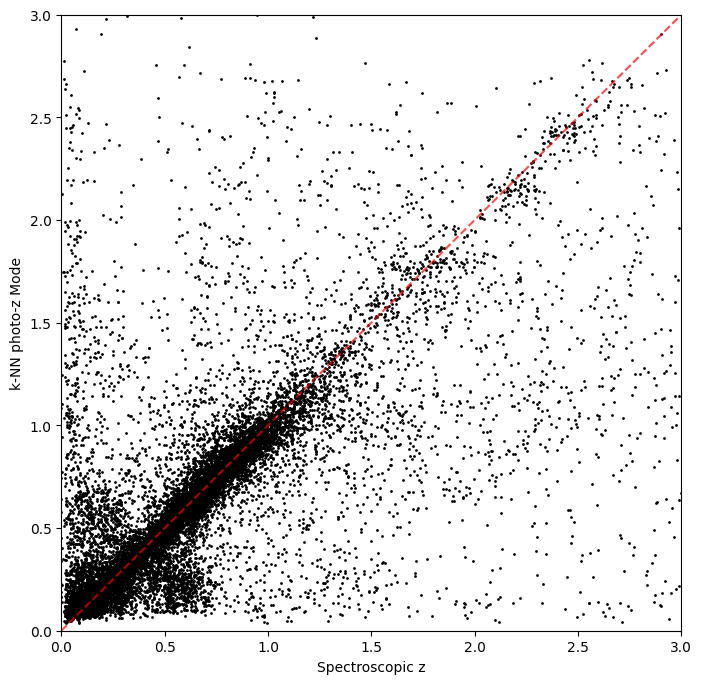

In [13]:
plt.figure(figsize=(8, 8))
# plt.scatter(test_data()['redshift'],zmode_knn,s=1,label='KNN mode')
plt.scatter(test_data()["redshift"], zmedian_knn, s=1, label="KNN mode", c="k")

plt.plot([0, 4], [0, 4], "r--", alpha=0.7)

plt.xlim(0, 3)
plt.ylim(0, 3)
plt.xlabel("Spectroscopic z")
plt.ylabel("k-NN photo-z Mode")

Not bad, given our very simple estimator!  For the PDFs, `KNearNeigh` is storing each PDF as a Gaussian mixture model parameterization where each PDF is represented by a set of N Gaussians for each galaxy.  `qp.Ensemble` objects have all the methods of `scipy.stats.rv_continuous` objects so we can evaluate the PDF on a set of grid points with the built-in `.pdf` method.  Let's pick a single galaxy from our sample and evaluate and plot the PDF, the mode, and true redshift:

Text(0, 0.5, 'p(z)')

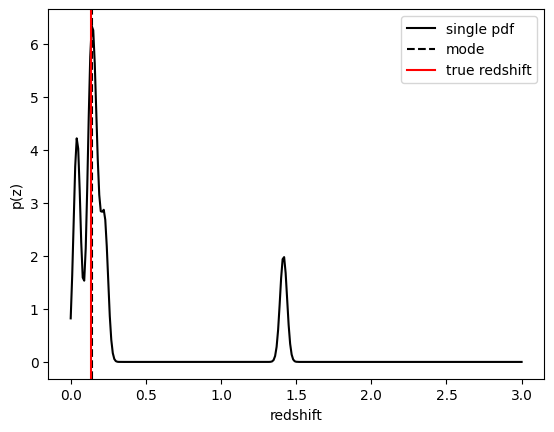

In [14]:
zgrid = np.linspace(0, 3.0, 301)
galid = 1024
single_gal = np.squeeze(results_knn()[galid].pdf(zgrid))
single_zmode = zmode_knn[galid]
truez = np.array(test_data()["redshift"])[galid]

plt.plot(zgrid, single_gal, color="k", label="single pdf")
plt.axvline(single_zmode, color="k", ls="--", label="mode")
plt.axvline(truez, color="r", label="true redshift")
plt.legend(loc="upper right")
plt.xlabel("redshift")
plt.ylabel("p(z)")

## FlexZBoost

That illustrates the basics. Now let's try the `FlexZBoostEstimator` estimator.  FlexZBoost is available in the [rail_flexzboost](https://github.com/LSSTDESC/rail_flexzboost/) repo and can be installed with

`pip install pz-rail-flexzboost`

on the command line or from source.  Once installed, it will function the same as any of the other estimators included in the primary `rail` repo.

`FlexZBoostEstimator` approximates the conditional density estimate for each PDF with a set of weights on a set of basis functions.  This can save space relative to a gridded parameterization, but it also leads to residual "bumps" in the PDF intrinsic to the underlying cosine or fourier parameterization.  For this reason, `FlexZBoostEstimator` has a post-processing stage where it "trims" (i.e. sets to zero) any small peaks, or "bumps", below a certain `bump_thresh` threshold.

One of the dominant features seen in our PhotoZDC1 analysis of multiple photo-z codes (Schmidt, Malz et al. 2020) was that photo-z estimates were often, in general, overconfident or underconfident in their overall uncertainty in PDFs.  To remedy this, `FlexZBoostEstimator` has an additional post-processing step where it applies a "sharpening" parameter `sharpen` that modulates the width of the PDFs according to a power law.

A portion of the training data is held in reserve to determine best-fit values for both `bump_thresh` and `sharpening`, which we currently find by simply calculating the CDE loss for a grid of `bump_thresh` and `sharpening` values; once those values are set FlexZBoost will re-train its density estimate model with the full dataset. A more sophisticated hyperparameter fitting procedure may be implemented in the future.

We'll start with a dictionary of setup parameters for FlexZBoostEstimator, just as we had for the k-nearest neighbor estimator.  Some of the parameters are the same as in k-nearest neighbor above, `zmin`, `zmax`, `nzbins`.  However, FlexZBoostEstimator performs a more in depth training and as such has more input parameters to control its behavior.  These parameters are:

- `basis_system`: which basis system to use in the density estimate. The default is `cosine` but `fourier` is also an option
- `max_basis`: the maximum number of basis functions parameters to use for PDFs
- `regression_params`: a dictionary of options fed to `xgboost` that control the maximum depth and the `objective` function.  An update in `xgboost` means that `objective` should now be set to `reg:squarederror` for proper functioning.
- `trainfrac`: The fraction of the training data to use for training the density estimate.  The remaining galaxies will be used for validation of `bump_thresh` and `sharpening`.
- `bumpmin`: the minimum value to test in the `bump_thresh` grid
- `bumpmax`: the maximum value to test in the `bump_thresh` grid
- `nbump`: how many points to test in the `bump_thresh` grid
- `sharpmin`, `sharpmax`, `nsharp`: same as equivalent `bump_thresh` params, but for `sharpening` parameter

In [15]:
fz_dict = dict(
    zmin=0.0,
    zmax=4.0,
    nzbins=401,
    trainfrac=0.75,
    bumpmin=0.02,
    bumpmax=0.35,
    nbump=20,
    sharpmin=0.7,
    sharpmax=2.1,
    nsharp=15,
    max_basis=35,
    basis_system="cosine",
    hdf5_groupname="",
    regression_params={"max_depth": 8, "objective": "reg:squarederror"},
)
fz_modelfile = "model/demo_FZB_model.pkl"

create the inform stage of flexzboost

In [16]:
from rail.estimation.algos.flexzboost import FlexZBoostInformer, FlexZBoostEstimator

fzb_informer = FlexZBoostInformer.make_stage(
    name="inform_fzboost", model=fz_modelfile, **fz_dict
)

`FlexZBoostInformer` operates on the training set and writes a file containing the estimation model.  `FlexZBoost` uses xgboost to determine a conditional density estimate model, and also fits the `bump_thresh` and `sharpen` parameters described above.

`FlexZBoost` is a bit more sophisticated than the earlier k-nearest neighbor estimator, so it will take a bit longer to train, but not drastically so, still under a minute on a semi-new laptop.  We specified the name of the model file, `demo_FZB_model.pkl`, which will store our trained model for use with the estimation stage.

In [17]:
%%time
fzb_informer.inform(training_data)

stacking some data...
read in training data
fit the model...
finding best bump thresh...
finding best sharpen parameter...
Retraining with full training set...
Inserting handle into data store.  model_inform_fzboost: model/inprogress_demo_FZB_model.pkl, inform_fzboost
CPU times: user 1min 41s, sys: 20.5 s, total: 2min 1s
Wall time: 2min 14s


Similar to the k-NN step, we now initialize the estimation stage of the FlexZBoost estimator. 
We directly take the model data from the informer stage `fzb_informer`. The output path is specified by `output`.

In [18]:
%%time
fzb_estimator = FlexZBoostEstimator.make_stage(
    name="fzboost",
    hdf5_groupname="photometry",
    model=fzb_informer.get_handle("model"),
    output="./output/output_fzboost.hdf5",
)

CPU times: user 135 µs, sys: 27 µs, total: 162 µs
Wall time: 167 µs


In [19]:
%%time
results_fzb = fzb_estimator.estimate(test_data)

Process 0 running estimator on chunk 0 - 10000
Process 0 estimating PZ PDF for rows 0 - 10,000
Inserting handle into data store.  output_fzboost: output/inprogress_output_fzboost.hdf5, fzboost
Process 0 running estimator on chunk 10000 - 20000
Process 0 estimating PZ PDF for rows 10,000 - 20,000
CPU times: user 13.3 s, sys: 1.39 s, total: 14.7 s
Wall time: 13.7 s


In [20]:
fz_medians = results_fzb().ancil["zmedian"].flatten()
fz_modes = results_fzb().ancil["zmode"].flatten()

Text(0, 0.5, 'Number')

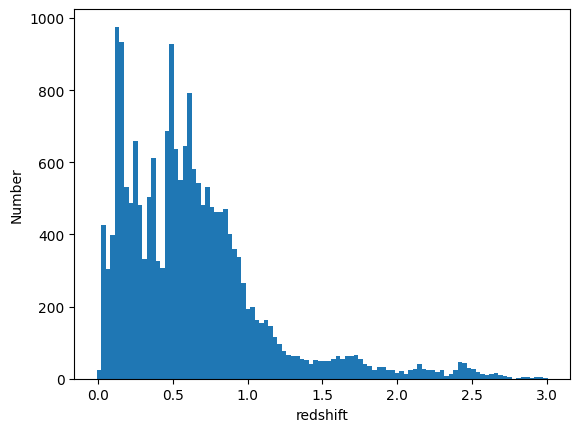

In [21]:
plt.hist(fz_medians, bins=np.linspace(-0.005, 3.005, 101))
plt.xlabel("redshift")
plt.ylabel("Number")

Text(0.5, 1.0, 'mode point estimate derived from FlexZBoost PDFs')

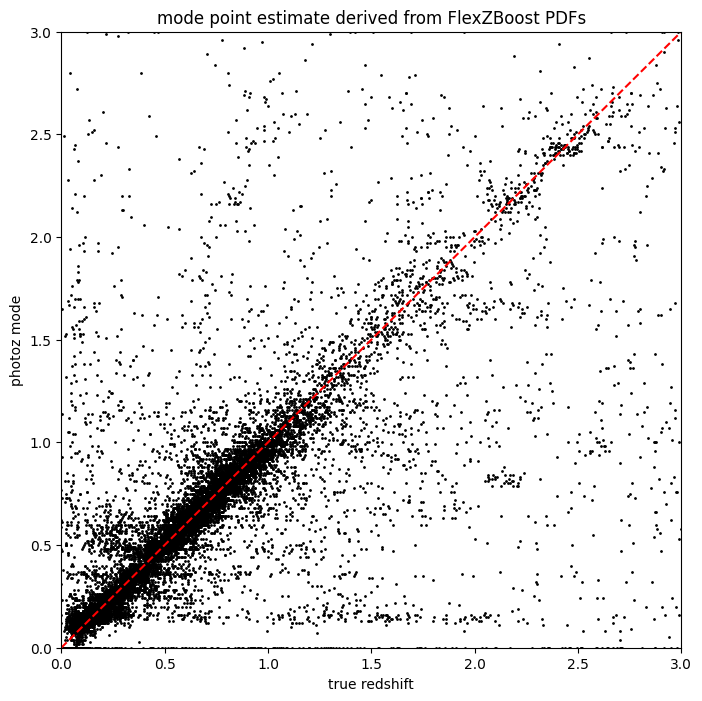

In [22]:
plt.figure(figsize=(8, 8))
plt.scatter(test_data()["redshift"], fz_modes, s=1, c="k")
plt.plot([0, 3], [0, 3], "r--")
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.xlabel("true redshift")
plt.ylabel("photoz mode")
plt.title("mode point estimate derived from FlexZBoost PDFs")

## BPZ

This part will go through a simple example of running rail_bpz estimate and inform stages with a small set of test data that ships with the RAIL package.

In [23]:
from rail.utils.path_utils import RAILDIR
from rail.core.data import ModelHandle
from rail.estimation.algos.bpz_lite import BPZliteInformer, BPZliteEstimator

## running BPZliteEstimator with a pre-existing model

BPZ is a template-fitting code that works by calculating the chi^2 value for observed photometry and errors compared with a grid of theoretical photometric fluxes generated from a set of template SEDs at each of a grid of redshift values.  These chi^2 values are converted to likelihoods.  If desired, a Bayesian prior can be applied that parameterizes the expected distribution of galaxies in terms of both probability of a "broad" SED type as a function of apparent magnitude, and the probability of a galaxy being at a certain redshift given broad SED type and apparent magnitude.  The product of this prior and the likelihoods is then summed over the SED types to return a marginalized posterior PDF, or p(z) for each galaxy.  If the config option `no_prior` is set to `True`, then no prior is applied, and BPZliteEstimator will return a likelihood for each galaxy rather than a posterior.


We need to set up a RAIL stage for the default run of BPZ, including specifying the location of the model pickle file, which is located included in the `rail_base` package and can be found relative to `RAILDIR` at `rail/examples_data/estimation_data/data/COSMOS31_HDFN_prior.pkl`.

In [24]:
cosmospriorfile = os.path.join(
    RAILDIR, "rail/examples_data/estimation_data/data/COSMOS31_HDFN_prior.pkl"
)
cosmosprior = DS.read_file("cosmos_prior", ModelHandle, cosmospriorfile)
sedfile = os.path.join(
    RAILDIR, "rail/examples_data/estimation_data/data/SED/COSMOS_seds.list"
)
hsc_config = "/hildafs/projects/phy200017p/ztq1996/ztq1996/RAIL/rail_bpz/src/rail/examples_data/estimation_data/configs/bpz_hsc.columns"
filter_path = RAILDIR + "/rail/examples_data/estimation_data/data/FILTER"

bpz_dict = dict(
    output="output/bpz_results_cosmos_matched.hdf5",
    prior_band="i_cModelMag",
    no_prior=False,
    spectra_file=sedfile,
    zp_errors=[0.1] * 5,
    columns_file=hsc_config,
)

bpz_estimator = BPZliteEstimator.make_stage(
    name="bpz_def_prior", model=cosmosprior, **bpz_dict
)

The `estimate` will perform template fitting to the galaxy dataset

In [25]:
bpz_estimator.estimate(training_data)

Process 0 running estimator on chunk 0 - 10000
Inserting handle into data store.  output_bpz_def_prior: output/inprogress_bpz_results_cosmos_matched.hdf5, bpz_def_prior
Process 0 running estimator on chunk 10000 - 20000


In [26]:
results_bpz = qp.read("./output/bpz_results_cosmos_matched.hdf5")
sz = training_data()["redshift"]

Make a plot to show the BPZ mode vs. spec-z

(-0.005, 3.0)

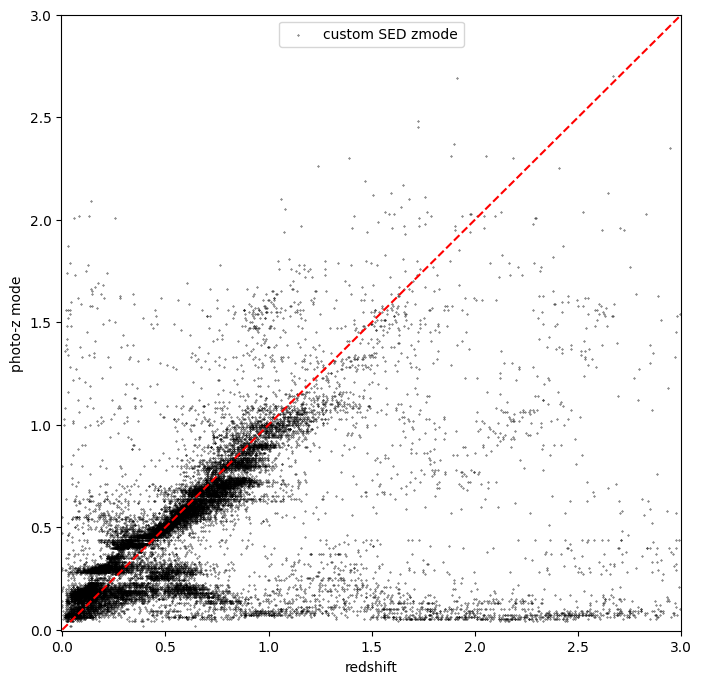

In [27]:
plt.figure(figsize=(8, 8))
plt.scatter(
    sz, results_bpz.ancil["zmode"].flatten(), s=0.1, c="k", label="custom SED zmode"
)
plt.plot([0, 3], [0, 3], "r--")
plt.xlabel("redshift")
plt.ylabel("photo-z mode")
plt.legend(loc="upper center", fontsize=10)
plt.xlim(-0.005, 3)
plt.ylim(-0.005, 3)

## Evaluation

The part of this notebook is to demonstrate the application of the metrics scripts to be used on the photo-z PDF catalogs produced by the PZ working group. The first implementation of the _evaluation_ module is based on the refactoring of the code used in [Schmidt et al. 2020](https://arxiv.org/pdf/2001.03621.pdf), available on Github repository [PZDC1paper](https://github.com/LSSTDESC/PZDC1paper). 


In [28]:
import tables_io
import pandas as pd

from rail.evaluation.dist_to_dist_evaluator import DistToDistEvaluator
from rail.evaluation.dist_to_point_evaluator import DistToPointEvaluator
from rail.evaluation.point_to_point_evaluator import PointToPointEvaluator

# from rail.evaluation.single_evaluator import SingleEvaluator
from rail.core.stage import RailStage
from rail.core.data import QPHandle, TableHandle, QPOrTableHandle

In [29]:
ztrue_data = DS.read_file("ztrue_data", TableHandle, testFile)
qp_knn = DS.read_file(
    key="qp_knn", handle_class=QPHandle, path="./output/knn_output.hdf5"
)
qp_fzb = DS.read_file(
    key="qp_fzb", handle_class=QPHandle, path="./output/output_fzboost.hdf5"
)
qp_bpz = DS.read_file(
    key="qp_bpz", handle_class=QPHandle, path="./output/bpz_results_cosmos_matched.hdf5"
)

column_list None


## Point to Point Evaluation

The {pomtToPointEvaluator is for evaluating metrics that compare point estimates (for the p(z)) to point values (for the reference or truth).

To test it we are going to compare the mode of p(z) distribution to true redshifts.

Note that as for the DistToDistEvaluator this can be run in parallel or forced to run on a single node for exact results.


We will run 5 different estimates, follow the links to get more information about each:
1. point_stats_ez: `(estimate - reference) / (1.0 + reference)`
2. point_stats_iqr: 'Interquatile range from 0.25 to 0.75', i.e., the middle 50% of the distribution of point_stats_ez
3. point_bias: Median of point_stats_ez
4. point_outlier_rate: Fraction of distribution outside of 3 sigma
5. point_stats_sigma_mad: Sigma of the median absolute deviation

In [30]:
stage_dict = dict(
    metrics=[
        "point_stats_ez",
        "point_stats_iqr",
        "point_bias",
        "point_outlier_rate",
        "point_stats_sigma_mad",
    ],
    _random_state=None,
    hdf5_groupname="",
    point_estimate_key="zmode",
    chunk_size=100000,
    reference_dictionary_key="redshift",
    metric_config={"point_stats_iqr": {"tdigest_compression": 100}},
)

ptp_stage_bpz = PointToPointEvaluator.make_stage(
    name="point_to_point_bpz", **stage_dict
)
# ptp_stage_single = PointToPointEvaluator.make_stage(name='point_to_point', force_exact=True, **stage_dict)
ptp_results_bpz = ptp_stage_bpz.evaluate(qp_bpz, ztrue_data)
results_bpz = tables_io.convertObj(
    ptp_stage_bpz.get_handle("summary")(), tables_io.types.PD_DATAFRAME
)

Requested metrics: ['point_stats_ez', 'point_stats_iqr', 'point_bias', 'point_outlier_rate', 'point_stats_sigma_mad']
Processing 0 running evaluator on chunk 0 - 20000.
Inserting handle into data store.  output_point_to_point_bpz: inprogress_output_point_to_point_bpz.hdf5, point_to_point_bpz
Inserting handle into data store.  summary_point_to_point_bpz: inprogress_summary_point_to_point_bpz.hdf5, point_to_point_bpz
Inserting handle into data store.  single_distribution_summary_point_to_point_bpz: inprogress_single_distribution_summary_point_to_point_bpz.hdf5, point_to_point_bpz


NOTE/WARNING: Expected output file single_distribution_summary_point_to_point_bpz.hdf5 was not generated.


In [31]:
ptp_stage_fzb = PointToPointEvaluator.make_stage(
    name="point_to_point_fzb", **stage_dict
)
ptp_results_fzb = ptp_stage_fzb.evaluate(qp_fzb, test_data)
results_fzb = tables_io.convertObj(
    ptp_stage_fzb.get_handle("summary")(), tables_io.types.PD_DATAFRAME
)

Requested metrics: ['point_stats_ez', 'point_stats_iqr', 'point_bias', 'point_outlier_rate', 'point_stats_sigma_mad']
Processing 0 running evaluator on chunk 0 - 20000.
Inserting handle into data store.  output_point_to_point_fzb: inprogress_output_point_to_point_fzb.hdf5, point_to_point_fzb
Inserting handle into data store.  summary_point_to_point_fzb: inprogress_summary_point_to_point_fzb.hdf5, point_to_point_fzb
Inserting handle into data store.  single_distribution_summary_point_to_point_fzb: inprogress_single_distribution_summary_point_to_point_fzb.hdf5, point_to_point_fzb


NOTE/WARNING: Expected output file single_distribution_summary_point_to_point_fzb.hdf5 was not generated.


In [32]:
ptp_stage_knn = PointToPointEvaluator.make_stage(
    name="point_to_point_knn", **stage_dict
)
ptp_results_knn = ptp_stage_fzb.evaluate(qp_knn, ztrue_data)
results_knn = tables_io.convertObj(
    ptp_results_knn["summary"].data, tables_io.types.PD_DATAFRAME
)

Requested metrics: ['point_stats_ez', 'point_stats_iqr', 'point_bias', 'point_outlier_rate', 'point_stats_sigma_mad']
Processing 0 running evaluator on chunk 0 - 20000.
Inserting handle into data store.  output_point_to_point_fzb: inprogress_output_point_to_point_fzb.hdf5, point_to_point_fzb
Inserting handle into data store.  summary_point_to_point_fzb: inprogress_summary_point_to_point_fzb.hdf5, point_to_point_fzb
Inserting handle into data store.  single_distribution_summary_point_to_point_fzb: inprogress_single_distribution_summary_point_to_point_fzb.hdf5, point_to_point_fzb


NOTE/WARNING: Expected output file single_distribution_summary_point_to_point_fzb.hdf5 was not generated.


In [33]:
results_stacked = pd.concat([results_bpz, results_fzb, results_knn])
results_stacked["method"] = ["BPZ", "flexZboost", "knn"]
results_stacked = results_stacked[
    [
        "method",
        "point_stats_iqr",
        "point_bias",
        "point_outlier_rate",
        "point_stats_sigma_mad",
    ]
]

In [34]:
print(results_stacked.to_string(index=False))

    method  point_stats_iqr  point_bias  point_outlier_rate  point_stats_sigma_mad
       BPZ         0.315767   -0.071771            0.012550               0.312238
flexZboost         0.037276   -0.001229            0.163100               0.036094
       knn         0.043126   -0.001969            0.191975               0.040691


## Dist to Point Evaluation

The DistToPointEvaluator is for evaluating metrics that compare distributions (for the p(z)) estimate to point values (for the reference or truth).

To test it we are going to compare a generated p(z) distribution to true redshifts.

Note that as for the DistToDistEvaluator this can be run in parallel or forced to run on a single node for exact results.

We will run 3 different estimates, follow the links to get more information about each:
1. cdeloss: [Conditional Density Estimation](https://vitaliset.github.io/conditional-density-estimation/)
2. pit: [Probability Integral Transform](https://en.wikipedia.org/wiki/Probability_integral_transform)
3. brier: [Brier Score](https://en.wikipedia.org/wiki/Brier_score)

In [35]:
eval_dict = dict(bpz=qp_bpz, fzboost=qp_fzb, knn=qp_knn)

evaluator_stage_dict = dict(
    metrics=["cdeloss", "pit", "brier"],
    _random_state=None,
    hdf5_groupname="",
    metric_config={
        "brier": {"limits": (0, 6.1)},
        "pit": {"tdigest_compression": 1000},
    },
)
truth = ztrue_data

result_dict = {}
for key, val in eval_dict.items():
    the_eval = DistToPointEvaluator.make_stage(
        name=f"{key}_dist_to_point", force_exact=True, **evaluator_stage_dict
    )
    result_dict[key] = the_eval.evaluate(val, truth)

Requested metrics: ['cdeloss', 'pit', 'brier']


Inserting handle into data store.  output_bpz_dist_to_point: inprogress_output_bpz_dist_to_point.hdf5, bpz_dist_to_point
Inserting handle into data store.  summary_bpz_dist_to_point: inprogress_summary_bpz_dist_to_point.hdf5, bpz_dist_to_point
Inserting handle into data store.  single_distribution_summary_bpz_dist_to_point: inprogress_single_distribution_summary_bpz_dist_to_point.hdf5, bpz_dist_to_point
Warning.  Failed to convert column No conversion path for dtype: dtype('<U16')
Requested metrics: ['cdeloss', 'pit', 'brier']


Inserting handle into data store.  output_fzboost_dist_to_point: inprogress_output_fzboost_dist_to_point.hdf5, fzboost_dist_to_point
Inserting handle into data store.  summary_fzboost_dist_to_point: inprogress_summary_fzboost_dist_to_point.hdf5, fzboost_dist_to_point
Inserting handle into data store.  single_distribution_summary_fzboost_dist_to_point: inprogress_single_distribution_summary_fzboost_dist_to_point.hdf5, fzboost_dist_to_point
Warning.  Failed to convert column No conversion path for dtype: dtype('<U16')
Requested metrics: ['cdeloss', 'pit', 'brier']


Inserting handle into data store.  output_knn_dist_to_point: inprogress_output_knn_dist_to_point.hdf5, knn_dist_to_point
Inserting handle into data store.  summary_knn_dist_to_point: inprogress_summary_knn_dist_to_point.hdf5, knn_dist_to_point
Inserting handle into data store.  single_distribution_summary_knn_dist_to_point: inprogress_single_distribution_summary_knn_dist_to_point.hdf5, knn_dist_to_point
Warning.  Failed to convert column No conversion path for dtype: dtype('<U16')


In [36]:
results_tables = {
    key: tables_io.convertObj(val["summary"].data, tables_io.types.PD_DATAFRAME)
    for key, val in result_dict.items()
}

In [37]:
grid = np.linspace(0, 1, 101)

pit = result_dict["fzboost"]["single_distribution_summary"].data["pit"].pdf(grid)

In [38]:
results_stacked = pd.concat(
    [results_tables["bpz"], results_tables["fzboost"], results_tables["knn"]]
)
results_stacked["method"] = ["BPZ", "flexZboost", "knn"]
results_stacked = results_stacked[["method", "cdeloss", "brier"]]

In [39]:
print(results_stacked.to_string(index=False))

    method   cdeloss      brier
       BPZ  1.646223 332.100314
flexZboost -5.011697 560.668948
       knn -4.183724 530.527747


## PIT-QQ plot

The histogram of PIT values is a useful tool for a qualitative assessment of PDFs quality. It shows whether the PDFs are:
* biased (tilted PIT histogram)
* under-dispersed (excess counts close to the boudaries 0 and 1)
* over-dispersed (lack of counts close the boudaries 0 and 1)
* well-calibrated (flat histogram)

Following the standards in DC1 paper, the PIT histogram is accompanied by the quantile-quantile (QQ), which can be used to compare qualitatively the PIT distribution obtained with the PDFs agaist the ideal case (uniform distribution). The closer the QQ plot is to the diagonal, the better is the PDFs calibration. 

In [40]:
from utils import plot_pit_qq, ks_plot

pit_out_rate = 0.001

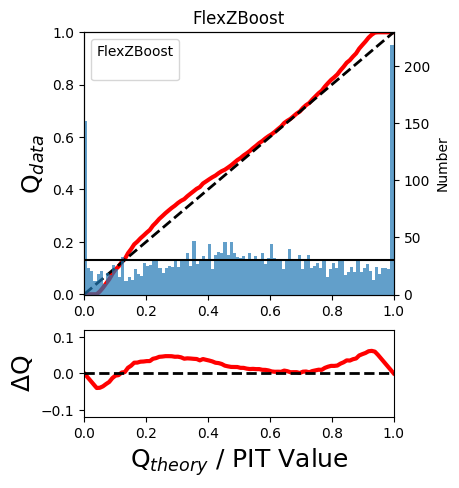

In [41]:
grid = np.linspace(0, 3, 301)
pdfs = qp_fzb().pdf(grid)[:3000, :]


plot_pit_qq(
    pdfs,
    zgrid,
    np.array(test_data()["redshift"])[:3000],
    title="FlexZBoost",
    code="FlexZBoost",
    savefig=False,
)